In [ ]:
# Nicolas Garavito
HW3 Astr 518

In [416]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [121]:
%pylab inline
font = {'size':18, 'family':'serif'}
plt.matplotlib.rc('font', **font)


Populating the interactive namespace from numpy and matplotlib


# 1

In [421]:
N = 10000
# Nsteps

In [423]:
def random_SN(N):
    """
    
    Function to generate N random homogeneous
    points inside an sphere or radius 2000 Mpc
    
    """
    
    r_max = 2000.
    r = np.random.random(N)
    
    cos_theta = np.random.random(N)*2.0-1.0
    phi = np.random.random(N)*2*pi
    theta = np.arccos(cos_theta)
    
    x = r**(1/2.0)*sin(theta)*cos(phi)*r_max
    y = r**(1/2.0)*sin(theta)*sin(phi)*r_max
    z = r**(1/2.0)*cos(theta)*r_max
    return x, y, z

In [424]:
xsn, ysn, zsn = random_SN(N)

# 1A


In [425]:
# From the MC somulation:
r = np.sqrt(xsn**2.0+ysn**2.0+zsn**2.0)
print('Mean distance from MC simulation:')
mean(r)

Mean distance from MC simulation:


1335.1986713787073

From theory I'll expect: 
\begin{equation}
\int_{0}^{r_f} Ardr = 1
\end{equation}

\begin{equation}
A \dfrac{r_f^2}{2} = 1
\end{equation}

Using $r_f = 2000$ 

\begin{equation}
A = 2.0 \times 10^{-6}
\end{equation}

\begin{equation}
<r> = \int_{0}^{r_f}A r^2dr = 1333.33 
\end{equation}

Theory and simulations agree!

# 1b

In [145]:
# Gaussian Abs. Magnitudes
N=100
xsn, ysn, zsn = random_SN(N)
Mag = np.random.normal(-19, 1, N)

In [294]:
def aparent_magnitudes(M, xyz):
    d = np.sqrt(xyz[:,0]**2.0+xyz[:,1]**2.0+xyz[:,2]**2.0)*1E6
    m = 5.0*log10(d) - 5 + M
    index  = np.where(m>20)[0] # cutting magnitudes wth m<20
    return m[index], d[index]

In [426]:
d = 10**((20+5-(-20))/5.0)

In [320]:
m, d_cut = aparent_magnitudes(Mag, np.array([xsn, ysn, zsn]).T) 

In [323]:
d = np.sqrt(xsn**2.0+ysn**2.0+zsn**2.0)
# b1)
v = d*72.0 # in km/s
# b2)
d_obs = 10**((m+19+5)/5.0)
v2 = d_cut*72.0/1E6

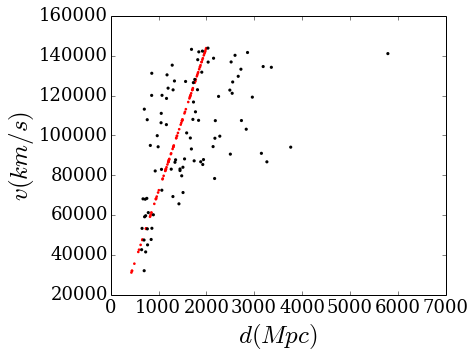

In [324]:
figsize(6,5)
scatter(d, v, s=7, c='r', edgecolor='none')
scatter(d_obs/1E6, v2, s=10, c='k', edgecolor='none')
xlabel('$d(Mpc)$', fontsize=25)
ylabel('$v(km/s)$', fontsize=25)
#xlim(0, 6000)

*Discussion:* The cut in the apparent magnitude remove 4 points of the 100. In general it also makes that most of the observations to be more far away from what they really are.

# 1.c

In [428]:
Hobs = np.mean(v2/d_obs*1E6)
print('Hubble constant from the mocked observations')
print('H_obs =', Hobs)

Hubble constant from the mocked observations
H_obs = 68.599850782


*Discussion:* The level of the bias is of $\sim 1\%$ the simplet solution (not the best)
would be to use the data in a distance range in which the data bias is not going to affect.
In this particle example it will be stars with a $d<1000Mpc$ This would reduce the ammount
of data! 

# 2.

In [19]:
data = np.loadtxt('../../Instrumentation/HW2.txt')
X = data[:,1]
Y = data[:,2]
sigma_y = data[:,3]

In [108]:
def likelihood(m, b, V, P, Yb):
    if ((P<0) | (P>=1)):
        L=0
    else:
        exp1 = (1-P)/(np.sqrt(2.*np.pi*sigma_y**2.0))*np.exp(-(Y-(m*X)-b)**2.0/(2.0*sigma_y**2.0))
        exp2 = P/(np.sqrt(2.0*np.pi*(sigma_y**2.0+V)))*np.exp(-(Y-Yb)**2.0/(2.0*(sigma_y**2.0+V)))
        L = np.prod(exp1+exp2)
    
    return L

In [109]:
def MCMC_ND(N_points, sigma_m, sigma_b, sigma_V, sigma_P, sigma_Y):
    L = np.zeros(N_points)
    m_walk= np.zeros(N_points)
    b_walk = np.zeros(N_points)
    V_walk = np.zeros(N_points)
    P_walk = np.zeros(N_points)
    Y_walk = np.zeros(N_points)

    acpt = 0
    m_walk[0] = 1.0
    b_walk[0] = 33
    V_walk[0] = 2000.
    P_walk[0] = 0.5
    Y_walk[0] = 350.
    
    L[0] = likelihood(m_walk[0], b_walk[0], V_walk[0], P_walk[0], Y_walk[0])

    for i in range(1,N_points):
        m_new = np.random.normal(m_walk[i-1], sigma_m)
        b_new = np.random.normal(b_walk[i-1], sigma_b)
        V_new = np.random.normal(V_walk[i-1], sigma_V)
        P_new = np.random.normal(P_walk[i-1], sigma_P)
        Y_new = np.random.normal(Y_walk[i-1], sigma_Y)

        L_new = likelihood(m_new, b_new, V_new, P_new, Y_new)
        R = L_new/L[i-1]
        if R>=1.0:
            m_walk[i] = m_new
            b_walk[i] = b_new
            V_walk[i] = V_new
            P_walk[i] = P_new
            Y_walk[i] = Y_new
            L[i] = likelihood(m_new, b_new, V_new, P_new, Y_new)
            acpt +=1          

        else:
            P = random.random(1)
            if P < R:
                m_walk[i] = m_new
                b_walk[i] = b_new
                V_walk[i] = V_new
                P_walk[i] = P_new
                Y_walk[i] = Y_new
                L[i] = likelihood(m_new, b_new, V_new, P_new, Y_new)
                acpt +=1
            else:
                m_walk[i] = m_walk[i-1]
                b_walk[i] = b_walk[i-1]
                V_walk[i] = V_walk[i-1]
                P_walk[i] = P_walk[i-1]
                Y_walk[i] = Y_walk[i-1]
                L[i] = L[i-1]
    return m_walk, b_walk, V_walk, P_walk, Y_walk, acpt

In [110]:
m_test, b_test, V_test, P_test, Y_test, acpt = MCMC_ND(300000, 0.1, 1, 100, 0.05, 50)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


# 2.a

What works better was to change the step size (dispersion of the gaussian that generates new values)
of the random walks of the 5 parameters according to their range of values. In real life this is 
not known a priori but after playing a little bit with them it's possible to find the best values.

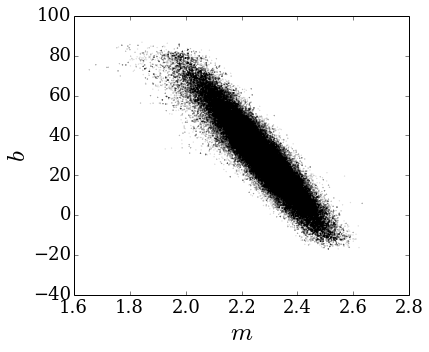

In [174]:
# 40000 -> length of the burning chain! chosen by looking at the plot bellow
scatter(m_test[40000:], b_test[40000:], s=0.1, c='k', alpha=0.2)
xlabel('$m$', fontsize=25)
ylabel('$b$', fontsize=25)

# 2.b

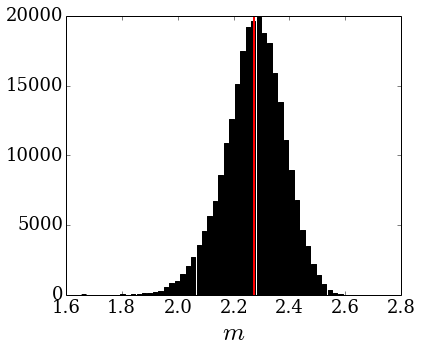

In [255]:
hm = hist(m_test[40000:], bins=50, color='k', rwidth=0.8)
xlabel('$m$', fontsize=25)
axvline(mean(m_test[40000:]),c='r', lw=2.)

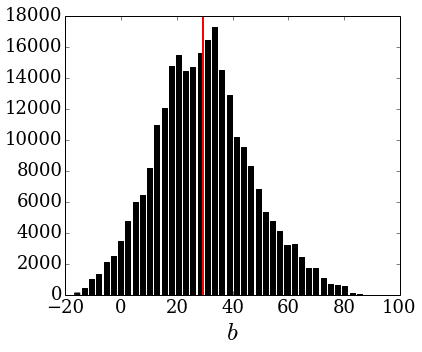

In [171]:
hb = hist(b_test[40000:], bins=40, color='k', rwidth=0.70)
xlabel('$b$', fontsize=25)
axvline(mean(b_test[40000:]),c='r', lw=2.)


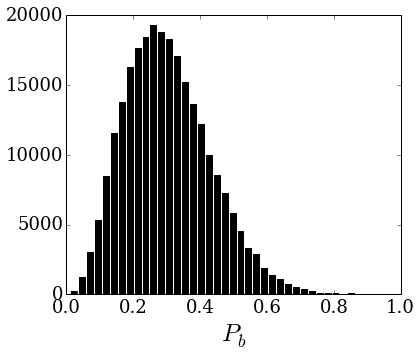

In [173]:
hP = hist(P_test[40000:], bins=40, color='k', rwidth=0.75)
xlabel('$P_b$', fontsize=25)



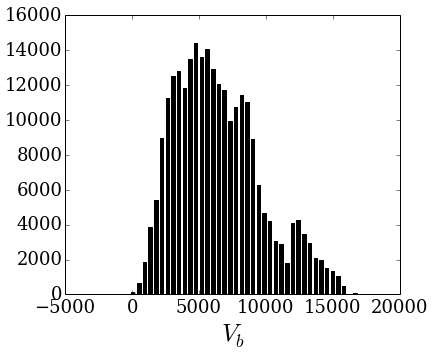

In [167]:
hV = hist(V_test[40000:], bins=40, color='k', rwidth=0.6)
xlabel('$V_b$', fontsize=25)

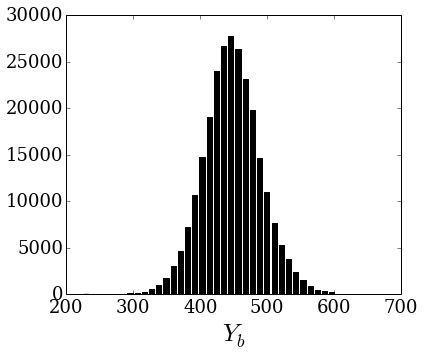

In [169]:
hY = hist(Y_test[40000:], bins=40, color='k', rwidth=0.72)
xlabel('$Y_b$', fontsize=25)

# 2c

In [349]:
from scipy import interpolate


In [409]:
def uncertainty(h, xmin, xmax):
    """
    Function to compute the uncertaities in assymetric
    PDF.
    
    """
    f = interpolate.interp1d(h[1][:-1], h[0])
    ms = np.linspace(xmin, xmax, 1000)
    ms_p = f(ms)

    error_l = np.where(ms<mean(m_test))[0]
    ms_l = ms[error_l]
    ms_pl = ms_p[error_l]

    error_r = np.where(ms>mean(m_test))[0]
    ms_r = ms[error_r]
    ms_pr = ms_p[error_r]

    ms_t = 10000
    prob = 0.
    while (prob < sum(ms_p)*0.95):
        index_l = np.argmin(np.abs(ms_t - ms_pl))
        index_r = np.argmin(np.abs(ms_t - ms_pr))
        index_cut = np.where((ms<ms_r[index_r]) & (ms>ms_l[index_l]))[0]
        #print(len(index_cut))
        prob = sum(ms_p[index_cut])
        ms_t -= 200
    return(min(ms[index_cut]), max(ms[index_cut]))

In [429]:
sigma_lm, sigma_rm = uncertainty(hm, 1.7, 2.6)
sigma_lb, sigma_rb = uncertainty(hb, -16, 80)

print('sigma_m_- = ', sigma_lm, 'sigma_m_+', sigma_rm)
print('sigma_b_-', sigma_lb, 'sigma_b_+', sigma_rb)

sigma_m_- =  2.04324324324 sigma_m_+ 2.46936936937
sigma_b_- -5.90990990991 sigma_b_+ 64.1441441441


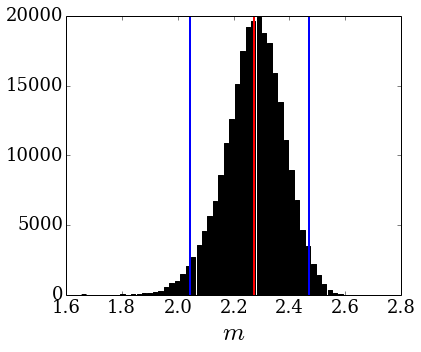

In [435]:
hm = hist(m_test[40000:], bins=50, color='k', rwidth=0.8)
xlabel('$m$', fontsize=25)
axvline(mean(m_test[40000:]),c='r', lw=2.)
axvline(sigma_lm, lw=2.)
axvline(sigma_rm, lw=2.)
xlabel('$m$', fontsize=25)


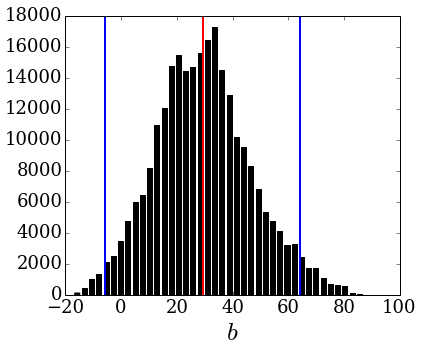

In [436]:
hb = hist(b_test[40000:], bins=40, color='k', rwidth=0.70)
xlabel('$b$', fontsize=25)
axvline(mean(b_test[40000:]),c='r', lw=2.)
axvline(sigma_lb, lw=2.)
axvline(sigma_rb, lw=2.)
xlabel('$b$', fontsize=25)

*Discussion*: this method is better than just taking 2$\sigma$ because as it can be 
seen from the PDF the functions are not necessary gaussian and therefore the uncertainties
are not symmetric around the mean. 